In [11]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from PBSHM_mdof.data.data_handler import HDF5Handler
from PBSHM_mdof.system.simulation import Simulation
from PBSHM_mdof.system.population import Population
from PBSHM_mdof.system.mdof_system import Mdof_system
import pandas as pd 

import h5py
import numpy as np
from tqdm import tqdm
from copy import deepcopy

In [13]:
from pathlib import Path 
systems_path = Path.cwd().parent/'data'/'systems'/'systems_healthy.json'
coefficent_path = Path.cwd().parent/'data'/'coefficients'/'coefficients.pkl'

In [14]:
population = Population()
population.load_population(systems_path)
k=population.systems_params['system_0']['stifness']

In [20]:
from dataclasses import dataclass
import pickle
def affect_temperature(population:Population,population_coef:np.ndarray,temperature:float):
    popluation_new = deepcopy(population)
    for sys_name,sys_param in popluation_new.systems_params.items():
        sys_param['stifness'] = sys_param['stifness']-temperature*population_coef[sys_name]

    return popluation_new

@dataclass
class Population_EOC_generator:
    population : Population
    population_coef_temperature : dict | None = None

    def __call__(self, temperature :float) -> Population:
        return self.affect_temperature(temperature)

    def generate_coefficients(self):
        coef = [1e-8,-200,-200,3575,-300,-3500,+1000,-450]
        coef *= np.random.normal(1,0.05,size=8)
        coef = np.array(coef)/10
        self.population_coef_temperature = {f'system_{i}':coef*np.random.normal(1,1e-2,size=8) for i in range(20)}

    def affect_temperature(self,temperature:float):
        return affect_temperature(self.population,self.population_coef_temperature,temperature)

    def coefficent_save(self,coefficent_path):
        with open(coefficent_path,'wb') as f:
            pickle.dump(self.population_coef_temperature,f)

    def coefficent_load(self,coefficent_path):
        with open(coefficent_path,'rb') as f:
            self.population_coef_temperature = pickle.load(f)

    


In [27]:
population_temp=Population_EOC_generator(population)
population_temp.generate_coefficients()
T= np.linspace(0,100,1000)
resultat = pd.DataFrame(columns=['t']+['freq '+str(i) for i in range(8)])
for t in T:
    population_affected = population_temp(temperature=t)
    population_affected.compute_systems_matrices()
    sys= population_affected.systems_matrices['system_0']
    sys = Mdof_system(**sys)
    eigs = sys.resonance_freqeuncy()
    
    resultat.loc[t] = [t]+list(eigs)
    

In [28]:
(resultat.iloc[-1,1:] - resultat.iloc[0,1:])*100/ resultat.iloc[0,1:]

freq 0    10.570
freq 1    -5.500
freq 2     1.352
freq 3    -6.640
freq 4    -6.105
freq 5    -4.711
freq 6   -15.600
freq 7    -5.611
dtype: float64

In [23]:
resultat.iloc[:,1:]=resultat.iloc[:,1:] - resultat.iloc[0,1:]

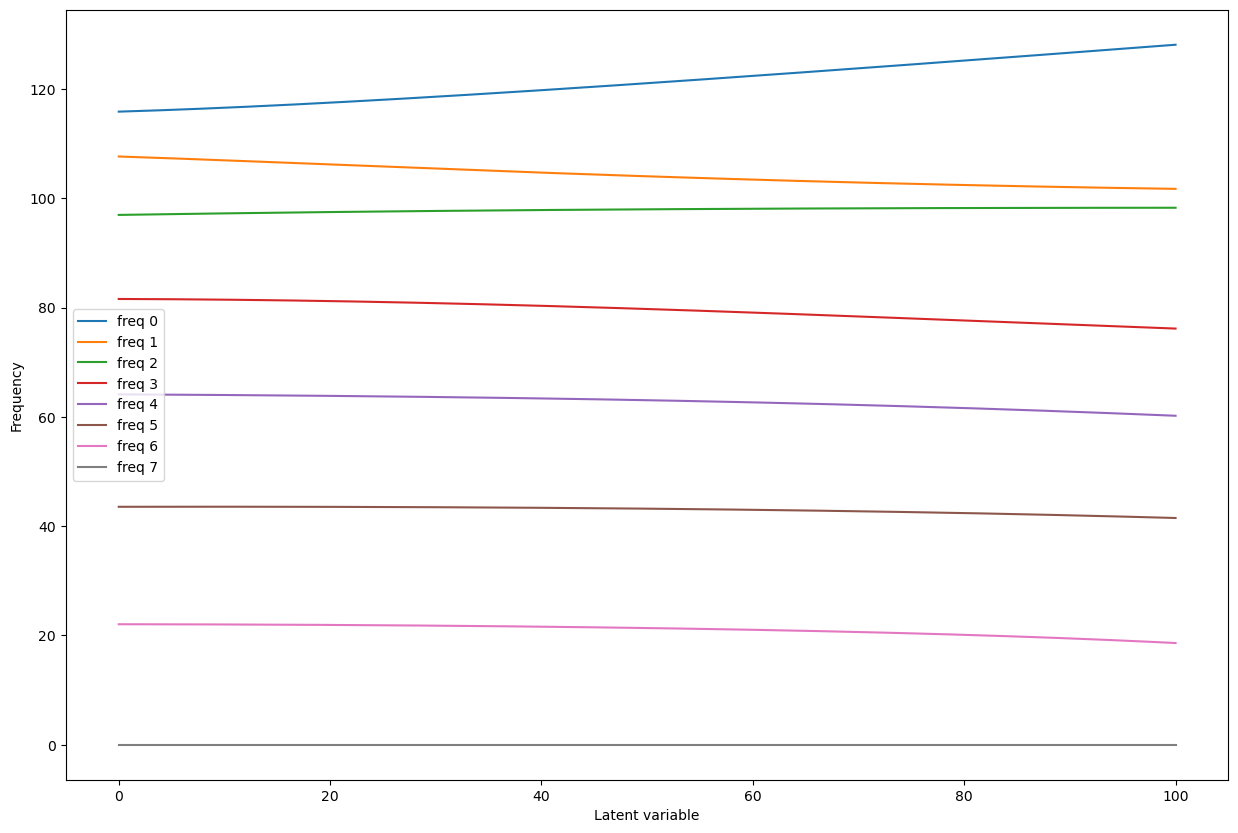

In [29]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots(figsize=(15,10))
for i in range(8):
    ax.plot(resultat['t'],resultat['freq '+str(i)],label='freq '+str(i))
ax.set_xlabel('Latent variable')
ax.set_ylabel('Frequency')

ax.legend()

In [ ]:
population_ano = deepcopy(population)
population_ano.add_anomaly(anomaly_size=anomaly_level/100)

In [35]:

anomaly_level= np.linspace(0,0.14,1000)
resultat = pd.DataFrame(columns=['anomaly_level']+['freq '+str(i) for i in range(8)])
for al in anomaly_level:
    population_ano = deepcopy(population)
    population_ano.add_anomaly(anomaly_size=al)
    sys= population_ano.systems_matrices['system_0']
    sys = Mdof_system(**sys)
    eigs = sys.resonance_freqeuncy()
    
    resultat.loc[al] = [al]+list(eigs)

In [198]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_mode_shape(mode_shape):
    # Create a grid of points to plot the mode shape
    
    x = np.arange(0, 8, 1)
    print(len(x))
    print(len(mode_shape))
    y = x + mode_shape

    # Plot the mode shape for each degree of freedom

    plt.plot(x,[0]*8, '-o',alpha=0.7)


    # Add labels and legend to the plot
    plt.xlabel('Position')
    plt.ylabel('Displacement')
    plt.title('Mode Shape')
    plt.legend()
    plt.show()


In [161]:
v,phi = sys.eigenvecs()
v = np.sqrt(v)
v=v[::2]
phi = phi[:,::2]


In [197]:
phi[0]

array([-8.64269879e-09-2.14698094e-06j,  1.30955296e-06+4.09668812e-04j,
       -3.20599104e-07-1.03821563e-04j,  6.29061636e-07+2.62854884e-04j,
        2.62276420e-06+1.38639602e-03j, -1.18889605e-06-9.11868817e-04j,
        2.41985501e-06+4.13793657e-03j,  3.53553345e-01+2.30980410e-21j])

In [194]:
sin_time =[]
for i in range(8):
    np.abs(phi[:,i])*np.sin(v[i]*time)


ValueError: operands could not be broadcast together with shapes (16,) (1000,) 

In [181]:
phi.shape

(16, 8)

In [182]:
sin_time@phi.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 1000)

In [177]:
time=np.linspace(0,10,1000)
x=np.einsum('j,ij->i',sin_time,phi)

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8
8


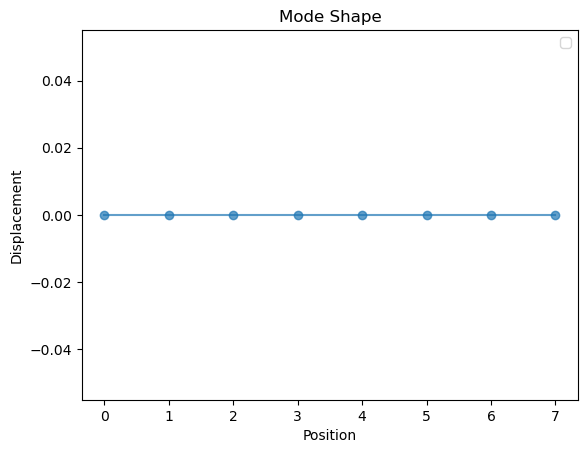

In [199]:
visualize_mode_shape(mode_shape)


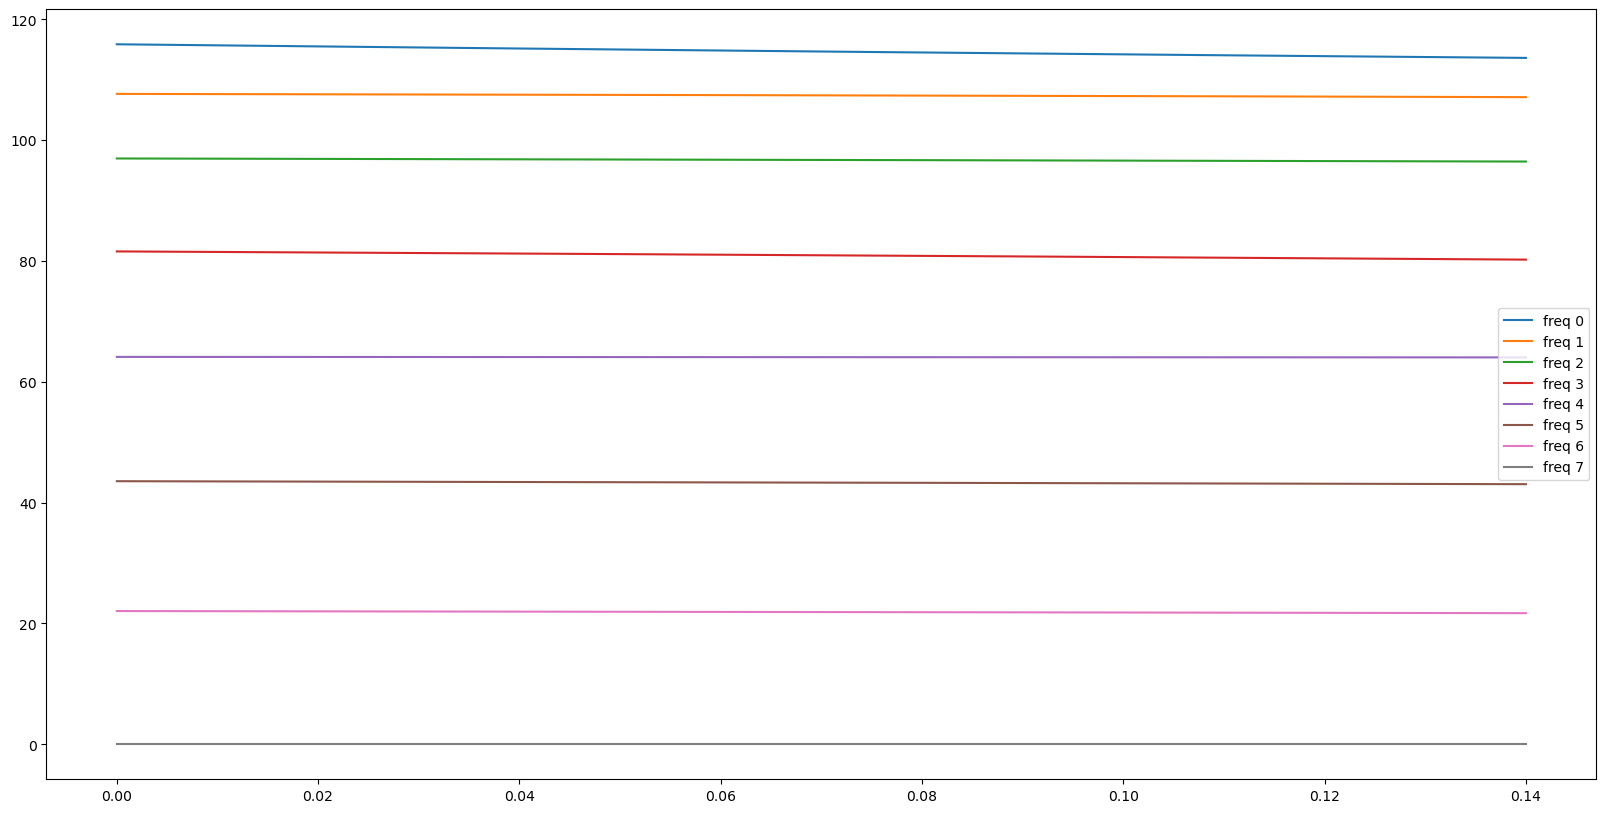

In [ ]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots(figsize=(20,10))
for i in range(8):
    ax.plot(resultat['anomaly_level'],resultat['freq '+str(i)],label='freq '+str(i))
ax.legend()

In [37]:
(resultat.iloc[-1,1:] - resultat.iloc[0,1:])*100/ resultat.iloc[0,1:]

freq 0   -1.945
freq 1   -0.501
freq 2   -0.526
freq 3   -1.668
freq 4   -0.130
freq 5   -1.133
freq 6   -1.583
freq 7   -0.003
dtype: float64

In [33]:
resultat.iloc[:,1:]=resultat.iloc[:,1:] - resultat.iloc[0,1:]

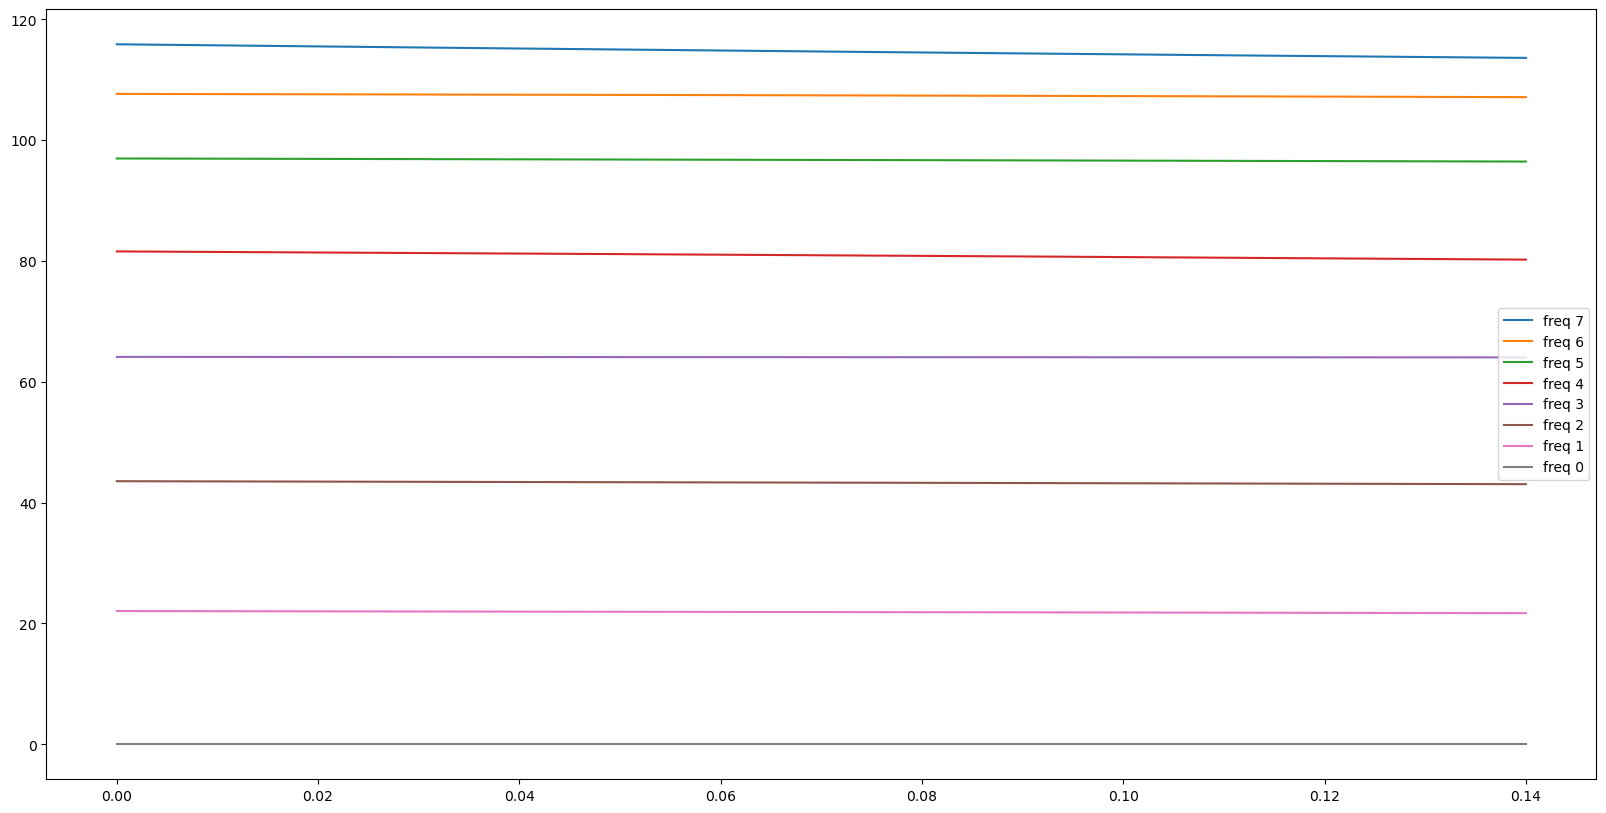

In [39]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots(figsize=(20,10))
for i in range(8):
    ax.plot(resultat['anomaly_level'],resultat['freq '+str(i)],label='freq '+str(i))
ax.legend()

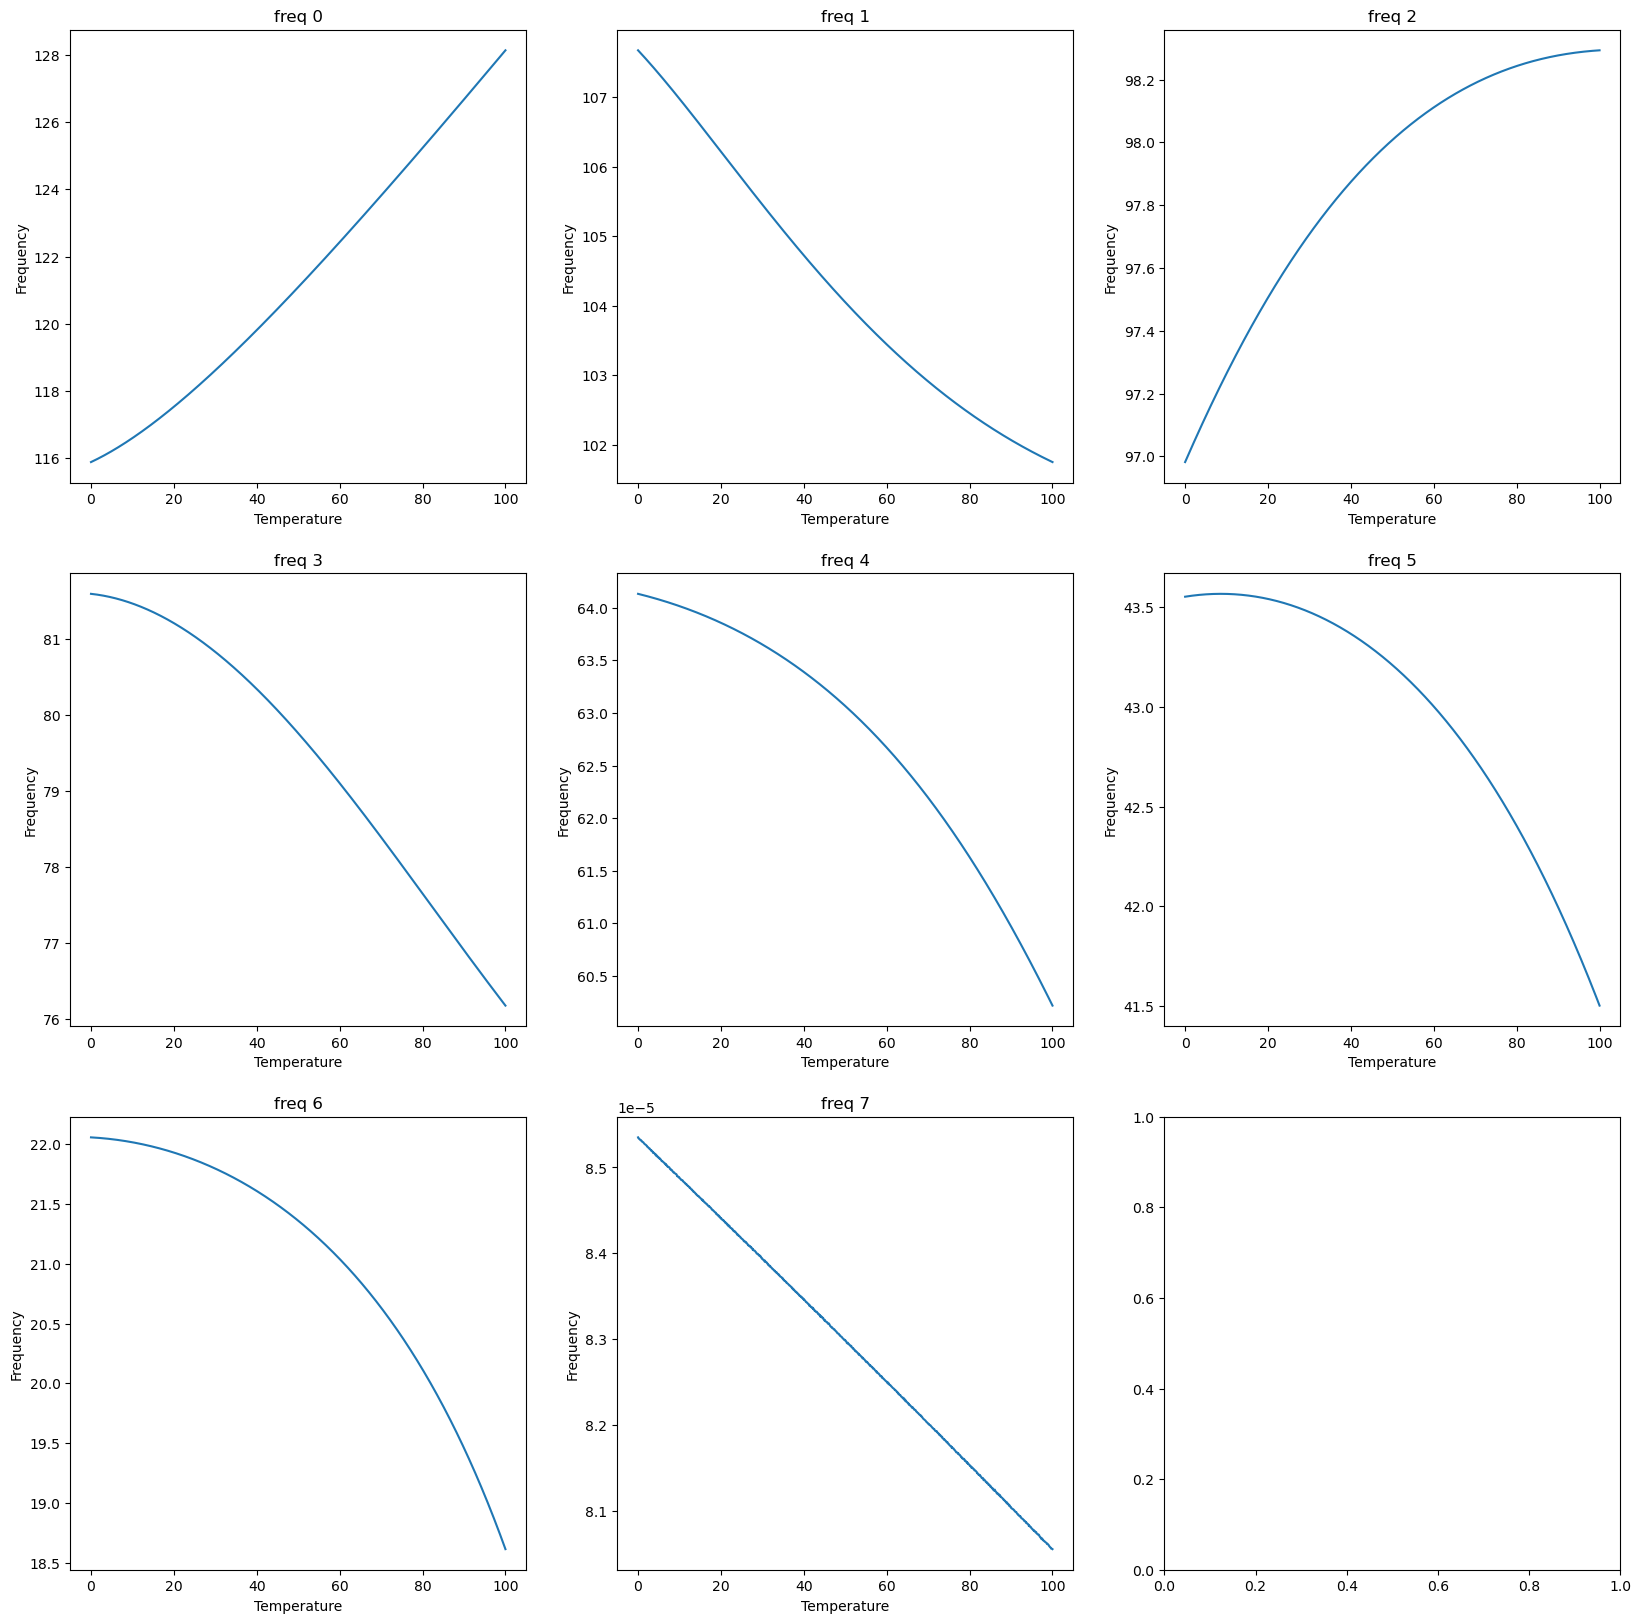

In [30]:
import matplotlib.pyplot as plt
from itertools import product
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,20))
for i,j in product(range(3),range(3)):
    if i+3*j>7:
        break
    ax[i,j].plot(resultat['t'],resultat['freq '+str(i*3+j)])
    ax[i,j].set_title('freq '+str(i*3+j))
    ax[i,j].set_xlabel('Temperature')
    ax[i,j].set_ylabel('Frequency')

In [130]:
1/2046

0.0004887585532746823

In [47]:
from scipy.signal import welch
def compute_PSD(signal_data,dt):
    f, psd = welch(signal_data, 1/dt, nperseg=2046, scaling='spectrum')
    return f, psd

In [106]:
1/20/0.0025

20.0

In [43]:
dt =0.0025
t = np.linspace(0,10,int(10/dt))
nsamples = len(t)
scale = np.random.uniform(0.5,30)
amplitude = np.random.uniform(0.5,3)
u = np.zeros((nsamples,8))
u[:,5] =  
u[1:,:]=0

In [44]:
u

array([[ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [45]:
acc7.shape

NameError: name 'acc7' is not defined

In [49]:
from PBSHM_mdof.system.simulation import Simulation
from tqdm import tqdm
temp = np.linspace(0,100,100)
psds =[]
for T in tqdm(temp):
    population_affected = population_temp(temperature=T)
    population_affected.compute_systems_matrices()
    sys = population_affected.systems_matrices['system_0']
    sys = Mdof_system(**sys)
    res = sys.simulate_lsim(u,t)
    acc7= res[1][:,2*8+1]
    f,psd = compute_PSD(acc7,dt)
    psds.append(psd)


100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


In [73]:
from PBSHM_mdof.system.simulation import Simulation
from tqdm import tqdm
temp = np.linspace(0,100,100)
psds =[]
for T in tqdm(temp):
    population_affected = population_temp(temperature=T)
    population_affected.compute_systems_matrices()
    sys = population_affected.systems_matrices['system_0']
    sys = Mdof_system(**sys)
    freq= np.linspace(0,150,1000)
    omega = freq * 2 * np.pi
    res = sys.transfer_function(omega,2,7)
    psds.append(res)


100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


In [74]:
psds= np.array(psds)


In [77]:
psdss=psds**2

In [79]:
psdss

array([[1.00476017e+12+0.00000000e+00j, 1.04883376e-01-9.51724578e-11j,
        6.55711242e-03-4.79053239e-11j, ...,
        7.00683028e-18+1.12041607e-18j, 6.74718231e-18+1.07811253e-18j,
        6.49777515e-18+1.03751503e-18j],
       [1.00688866e+12+0.00000000e+00j, 1.04883380e-01-9.52075831e-11j,
        6.55711333e-03-4.79225710e-11j, ...,
        7.00100127e-18+1.11968087e-18j, 6.74153046e-18+1.07739715e-18j,
        6.49229524e-18+1.03681903e-18j],
       [1.00912717e+12+0.00000000e+00j, 1.04883384e-01-9.52471851e-11j,
        6.55711436e-03-4.79420431e-11j, ...,
        6.99435087e-18+1.11883055e-18j, 6.73508446e-18+1.07657033e-18j,
        6.48604751e-18+1.03601517e-18j],
       ...,
       [1.25951342e+12+0.00000000e+00j, 1.04887652e-01-1.35654643e-10j,
        6.55818360e-03-6.81345269e-11j, ...,
        2.97534462e-18+5.25947945e-19j, 2.85526438e-18+5.03838147e-19j,
        2.74041629e-18+4.82737782e-19j],
       [1.26266646e+12+0.00000000e+00j, 1.04887799e-01-1.37039647e-1

/tmp/ipykernel_481886/1744302557.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(scm)


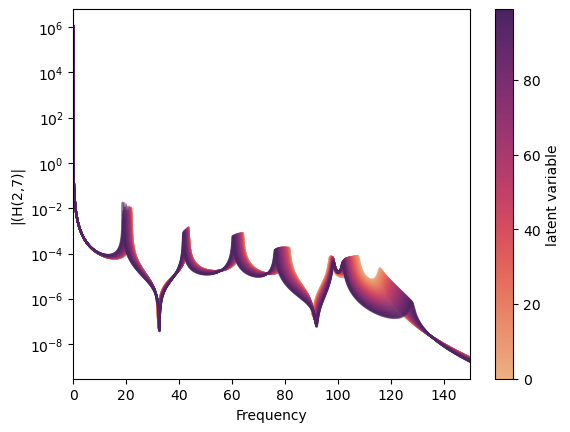

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

color = sns.color_palette('flare',len(temp))

fig, ax = plt.subplots()

for i in range(len(temp)):
    ax.plot(freq[:], np.abs(psds[i])[:], color=color[i], alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('|(H(2,7)|')

# create a scalar mappable with the 'flare' colormap
scm = plt.cm.ScalarMappable(cmap='flare')
scm.set_array(list(range(len(temp))))

# add a color bar to the plot
cbar = plt.colorbar(scm)

# set the label for the color bar
cbar.set_label('latent variable')
plt.margins(x=0)
plt.show()


In [22]:

def polyeig(*A):
    """
    Solve the polynomial eigenvalue problem:
        (A0 + e A1 +...+  e**p Ap)x=0 

    Return the eigenvectors [x_i] and eigenvalues [e_i] that are solutions.

    Usage:
        X,e = polyeig(A0,A1,..,Ap)

    Most common usage, to solve a second order system: (K + C e + M e**2) x =0
        X,e = polyeig(K,C,M)

    """
    if len(A)<=0:
        raise Exception('Provide at least one matrix')
    for Ai in A:
        if Ai.shape[0] != Ai.shape[1]:
            raise Exception('Matrices must be square')
        if Ai.shape != A[0].shape:
            raise Exception('All matrices must have the same shapes');

    n = A[0].shape[0]
    l = len(A)-1 
    # Assemble matrices for generalized problem
    C = np.block([
        [np.zeros((n*(l-1),n)), np.eye(n*(l-1))],
        [-np.column_stack( A[0:-1])]
        ])
    D = np.block([
        [np.eye(n*(l-1)), np.zeros((n*(l-1), n))],
        [np.zeros((n, n*(l-1))), A[-1]          ]
        ]);
    # Solve generalized eigenvalue problem
    e, X = np.linalg.eig(C, D);
    if np.all(np.isreal(e)):
        e=np.real(e)
    X=X[:n,:]

    # Sort eigenvalues/vectors
    #I = np.argsort(e)
    #X = X[:,I]
    #e = e[I]

    # Scaling each mode by max
    X /= np.tile(np.max(np.abs(X),axis=0), (n,1))

    return X, e